# RNN

In [19]:
import glob
import pandas as pd
import tensorflow as tf


from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np

import os #Miscellaneous operating system interfaces
#https://docs.python.org/3/library/os.html
#get current working directory
path = os.getcwd() + '\\images\\image_train'
path

'C:\\Users\\Edgar\\Documents\\Rakuten\\images\\image_train'

Données textuelles:

In [47]:
df_X = pd.read_csv(r'C:\Users\Edgar\Documents\Rakuten\X_train\X_train_lemma-FR_stop_words-FR_no_num-FR_remove_accents-FR_no_special-FR_lemma-EN_stop_words-EN_stop_words-DE_lemma-DE_steem-FR_steem-EN_steem-DE.csv',index_col =0)
df_y = pd.read_csv(r'C:\Users\Edgar\Documents\Rakuten\Y_train_CVw08PX.csv',index_col=0)

In [50]:
df_y['label'] = df_y['prdtypecode'].replace(df_y.prdtypecode.unique(), [*range(len(df_y.prdtypecode.unique()))])
df_y

,prdtypecode,label
0,10,0
1,2280,1
2,50,2
3,1280,3
4,2705,4
...,...,...
84911,40,18
84912,2583,12
84913,2280,1
84914,1560,7


Nombre de mots par texte:

In [51]:
df_X.rename(columns={'0':'text'},inplace=True)

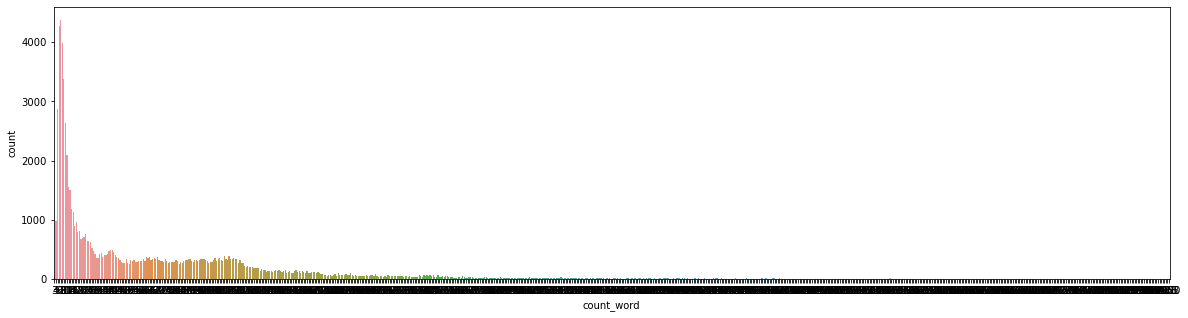

In [52]:
import seaborn as sns
from matplotlib import pyplot

df_X["count_word"] = df_X.text.apply(lambda x : len(x.split(' ')))

fig, ax = pyplot.subplots(figsize=(20,5))

sns.countplot(df_X["count_word"],ax=ax);

Pour éviter des séquences trop longue, le seuil maximum d'une phrase sera considéré à 40:

In [23]:
#df_X = df_X[df_X.count_word<=20]

#df_X["count_word"] = df_X.text.apply(lambda x : len(x.split(' ')))
#fig, ax = pyplot.subplots(figsize=(20,5))

#sns.countplot(df_X["count_word"],ax=ax)

Tokenisation:

In [24]:
#from sklearn.feature_extraction.text import TfidfVectorizer
#from nltk.tokenize import word_tokenize

#tfid = TfidfVectorizer(analyzer='word',
#                       tokenizer=word_tokenize,
#                       max_df=0.8,
#                       min_df=2,
#                       #ngram_range=(1,1),
#                       use_idf=True,
#                       smooth_idf=True,                       sublinear_tf=False,
#                       binary=True,
#                       max_features=10000
#                      )

#X = tfid.fit_transform(df_X['text'].squeeze()).todense()

#X.shape

Separer les données en train & text:

In [56]:
# Importer la classe train_test 
from sklearn.model_selection import train_test_split

# Séparer le jeu de données en données d'entraînement et données test 
X_train_text, X_test_text, y_train, y_test = train_test_split(df_X, df_y.label, test_size=0.2,random_state=42)

X_train_text

,text,count_word
60735,cart postal typo aim kiub cart postal tendanc ...,38
9118,garcon jeu plateau avoir propo agit un jeu car...,61
55855,royaum anim ab asc nan,6
42138,piscin jeu adress x,5
10948,unit stat european union auditor indep regul nan,9
...,...,...
6265,griottin coffret cl griottin coffret cl ceri g...,62
54886,bouquet tet artificiel pivoin soi feuill fleur...,86
76820,happi east tai oreil lin coussin sof hom decor...,66
860,pratiqu chass camo camp imperm camouflag furti...,164


Tokeniser: texte -> sequence entier (index dans un dictionaire):

In [57]:
import tensorflow as tf
# Définition du tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000)
# Mettre à jour le dictionnaire du tokenizer
tokenizer.fit_on_texts(X_train_text.text)

Stocker le dictionnaire de correspondance:

In [58]:
# Définition des dictionnaires
word2idx = tokenizer.word_index
idx2word = tokenizer.index_word
vocab_size = tokenizer.num_words

• Transformer chaque review X_text_train en une séquence d'entiers à l'aide de la méthode texts_to_sequences

In [59]:
X_train = tokenizer.texts_to_sequences(X_train_text.text)

X_test = tokenizer.texts_to_sequences(X_test_text.text)

• Transfomer la liste de sequence X_train en tableau numpy à l'aide de la fonction pad_sequences

In [60]:
maxlen = 500
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen, padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen, padding='post')

In [61]:
X_train

array([[ 112, 2600,  657, ...,    0,    0,    0],
       [ 679,   31,  754, ...,    0,    0,    0],
       [2721,  195,  410, ...,    0,    0,    0],
       ...,
       [1335, 4387,   63, ...,    0,    0,    0],
       [ 208,  736, 4951, ...,    0,    0,    0],
       [2665, 1985,  143, ...,    0,    0,    0]])

### Modèle RNN

In [62]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, RNN, GRUCell, Dropout
embedding_dim = 200

model = Sequential()
model.add(Embedding(10000, embedding_dim))
model.add(RNN(GRUCell(128), return_sequences=True))
model.add(Dropout(0.3))
model.add(GlobalAveragePooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(27, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
rnn_2 (RNN)                  (None, None, 128)         126720    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
global_average_pooling1d_2 ( (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 27)               

In [72]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [73]:
history = model.fit(X_train, y_train,
    batch_size = 64,
    epochs=10,
    validation_data = (X_test, y_test))

Epoch 1/10
1062/1062 [==============================] - 833s 783ms/step - loss: 0.3745 - accuracy: 0.8867 - val_loss: 0.7394 - val_accuracy: 0.8015
Epoch 2/10
1062/1062 [==============================] - 833s 785ms/step - loss: 0.2916 - accuracy: 0.9083 - val_loss: 0.7632 - val_accuracy: 0.8043
Epoch 3/10
1062/1062 [==============================] - 856s 806ms/step - loss: 0.2345 - accuracy: 0.9268 - val_loss: 0.8745 - val_accuracy: 0.8000
Epoch 4/10
1062/1062 [==============================] - 868s 818ms/step - loss: 0.1840 - accuracy: 0.9423 - val_loss: 0.9312 - val_accuracy: 0.8015
Epoch 5/10
1062/1062 [==============================] - 863s 813ms/step - loss: 0.1555 - accuracy: 0.9496 - val_loss: 1.0193 - val_accuracy: 0.7960
Epoch 6/10
1062/1062 [==============================] - 886s 834ms/step - loss: 0.1258 - accuracy: 0.9596 - val_loss: 1.1307 - val_accuracy: 0.7976
Epoch 7/10
1062/1062 [==============================] - 880s 828ms/step - loss: 0.1075 - accuracy: 0.9654 - val_